# DDPG algorithm implemented for single reacher continuous control environment

This notebook contains an implementation of the **DDPG** algorithm for solving the Unity's Reacher environment. Please follow the instructions to reproduce the results.

In [ ]:
# Adjusts the python path to the root of the repository. This must be run only once

%cd ..

In order to solve the environment, [DDPG](https://arxiv.org/abs/1509.02971) (Deep Deterministic Policy Gradient) algorithm has been used. It is an **actor-critic model-free algorithm** based on the [DPG](http://proceedings.mlr.press/v32/silver14.pdf) (Deterministic Policy Gradient) algorithm that can operate over **continuous action spaces**. The algorithm is defined as follows.

$$\nabla_{\theta^\mu}J = \mathop{\mathbb{E}}_{s_t \sim p^\beta} [\nabla_a Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta_\mu} \mu(s|\theta^\mu)|_{s=s_t}]$$

$$L(\theta^Q) = \mathop{\mathbb{E}}_{s \sim p^\beta, a_t \sim \beta, r_t \sim E}[(Q(s_t, a_t|\mu^Q)-y_t)^2]$$

where $y_t = r(s_t, a_t) + \gamma Q(s_{t+1}, \mu(s_{t+1})|_{\theta^Q})$, $\theta^Q$ are the parameters of the critic, $\theta^mu$ are the parameters of the actor, $E$ represents the environment, $\beta$ is the behavior policy and $\mu$ is the learned policy.

![DDPG Algorithm](../imgs/ddpg_algorithm.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from unityagents import UnityEnvironment

from src.agents import *
from src.rl_utilities import *

%matplotlib inline

## Instantiate the environment 

The code below initializes the Unity environment and extracts the main features of it. To set it up, please, follow the instructions below.

1. Download the environment from one of the links below.  You need only select the environment that matches your operating system:


- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux.zip)
- MacOSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Windows_x86.zip)
- Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Windows_x86_64.zip)
    
(_For Windows users_) Check out [this link](https://support.microsoft.com/en-us/help/827218/how-to-determine-whether-a-computer-is-running-a-32-bit-version-or-64) if you need help with determining if your computer is running a 32-bit version or 64-bit version of the Windows operating system.

(_For AWS_) If you'd like to train the agent on AWS (and have not [enabled a virtual screen](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Training-on-Amazon-Web-Service.md)), then please use [this link](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux_NoVis.zip) to obtain the environment.

2. Place the file in the DRLND GitHub repository, in the `envs` folder, and unzip (or decompress) the file. 

In [3]:
env_path = "<path to the single reacher environment>"
env = UnityEnvironment(env_path)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)

action_size = brain.vector_action_space_size

state = env_info.vector_observations
state_size = state.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Define the model parameters

In [ ]:
batch_size = 128  # Size of the batch to train the neural networks
n_episodes = 1000 # Number of episodes to run when training the agent
n_batches_train = 1 # Number of times to train for each time step
exp_replay_buffer_size = int(2e5) # Experience replay buffer size
epsilon_decay = 0.9925 # Decay of the exploration constant
epsilon = 1 # Initial value of the exploration constant
epsilon_final = 0.1 # Final value of the exploration constant
plot_every_n = 10 # Period to update the rewards chart
save_every_n = 100 # Period to save the model if an improvement has been found
tau = 0.001 # Parameter that controls how fast the local networks update the target networks
gamma = 0.99 # Discount factor

## Initialize the agent

In [ ]:
agent = DDPGAgent(CriticArchitecture, ActorArchitecture, state_size=state_size, action_size=action_size, 
                  tau=tau, gamma=gamma, batch_size=batch_size, replay_size = exp_replay_buffer_size,
                  n_batches_train=n_batches_train, random_seed=655321)
scores = [] 
epsilons = []
max_score = 0

## Run the training process

The following code runs the training process, reports the cumulative reward and saves the models weights

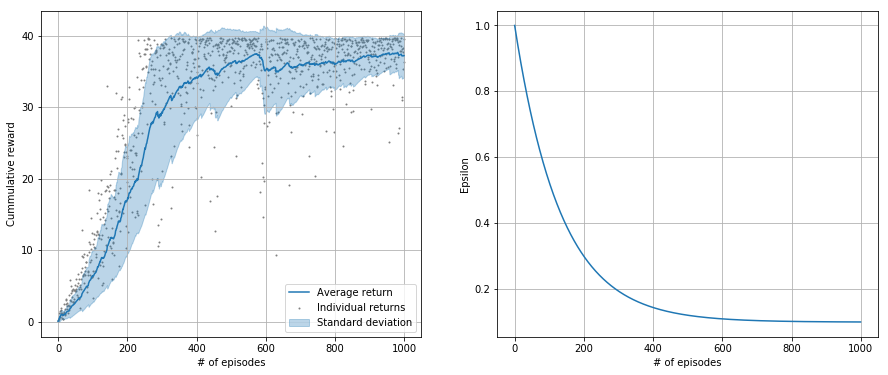

In [5]:
for episode in range(n_episodes):
    epsilons.append(epsilon)
    epsilon = epsilon_decay * epsilon + (1-epsilon_decay) * epsilon_final
    env_info = env.reset(train_mode=True)[brain_name] 
    agent.reset()
    state = env_info.vector_observations
    score = 0
    done = [False]
    c = 0
    while not any(done):
        # take random action
        action = agent.act(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += np.mean(reward)
        c += 1

    scores.append(score)
    
    if (episode+1) % plot_every_n == 0:
        clear_output(True)
        plt.figure(figsize=(15, 6))
        plt.subplot(1,2,1)
        plot_smoothed_return(scores)
        plt.subplot(1,2,2)
        plt.grid()
        plt.plot(epsilons)
        plt.xlabel("# of episodes")
        plt.ylabel("Epsilon")
        plt.show()
        
    if (episode + 1) % save_every_n == 0:
        if max_score < np.mean(scores[-100:]):    
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_target.pth')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_target.pth')
            max_score = np.mean(scores[-100:])


## Load and test the model 

In [5]:
agent = DDPGAgent(CriticArchitecture, ActorArchitecture, state_size=state_size, action_size=action_size, 
                  tau=0.001, epsilon=0.01, gamma=0.99, batch_size=batch_size, replay_size = exp_replay_buffer_size,
                  n_batches_train=n_batches_train, random_seed=655321)
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local.pth'))
agent.critic_target.load_state_dict(torch.load('checkpoint_critic_target.pth'))
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local.pth'))
agent.actor_target.load_state_dict(torch.load('checkpoint_actor_target.pth'))

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
done = False
c=0
agent.reset()
score=0
while not done:
    # take random action
    action = agent.act(state, epsilon=0)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score +=reward
    c += 1
    state = next_state

C:\Users\Ivan Valles Perez\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
